## Compare the models for pre-training

In [450]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from scipy import stats
from sklearn import metrics
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [451]:
GPU_TDP = 250 # watt
CPU_TDP = 85 # watt
memory_TDP = 9.4 # watt
time = 1.6679636111111111 # hours
GPU_utilisation =  98.41828958509737 #percentage
CPU_utilisation = 1 #assumed

In [452]:
dictionary = {'method':[],'energy':[]}
dict1 = {}

In [453]:
#mlco2 energy used = 0.4169909027777778 kWh
mlco2= (time * GPU_TDP) / 1000
dictionary['method'].append('time * GPU TDP')
dictionary['energy'].append(mlco2)
dict1['time * GPU TDP'] = [mlco2]

In [454]:
ai_and_compute = (time * GPU_TDP * 1/3) / 1000
dictionary['method'].append('time * GPU TDP * 1/3 util')
dictionary['energy'].append(ai_and_compute)
dict1['time * GPU TDP * 1/3 util'] = [ai_and_compute]

In [455]:
full_util = (time * (GPU_TDP + CPU_TDP + memory_TDP)) / 1000
dictionary['method'].append('time * (GPU+CPU+memory)')
dictionary['energy'].append(full_util)
dict1['time * (GPU+CPU+memory)'] = [full_util]

In [456]:
actual_util = (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation +memory_TDP)) / 1000
dictionary['method'].append('time * ((GPU+CPU+memory) * real_util)')
dictionary['energy'].append(actual_util)
dict1['time * ((GPU+CPU+memory) * real_util)'] = [actual_util]

In [457]:
# empirical values
# nvidia-smi GPU energy consumption = 0.43921391388888886 kWh
# GPU + CPU energy consumption = 0.5627291196798899 kWh
# power monitor reading = 0.6127022608333333 kWh
power_monitor_reading = 0.6127022608333333
dictionary['method'].append('empirical')
dictionary['energy'].append(power_monitor_reading)
dict1['empirical'] = [power_monitor_reading]

In [458]:
df= pd.DataFrame(dictionary)

In [504]:
df_co2 = pd.read_csv("results/co2data.csv")
uk_co2 = df_co2.loc[df_co2.country == 'United Kingdom'].impact.mean()
df['CO_2e'] = (df['energy'] * uk_co2) / 1000

In [505]:
df

,method,energy,CO_2e
0,time * GPU TDP,0.416991,0.105499
1,time * GPU TDP * 1/3 util,0.138997,0.035166
2,time * (GPU+CPU+memory),0.574447,0.145335
3,time * ((GPU+CPU+memory) * real_util),0.567851,0.143666
4,empirical,0.612702,0.155014


In [460]:
alt_df = pd.DataFrame(dict1)

In [461]:
alt_df

,time * GPU TDP,time * GPU TDP * 1/3 util,time * (GPU+CPU+memory),time * ((GPU+CPU+memory) * real_util),empirical
0,0.416991,0.138997,0.574447,0.567851,0.612702


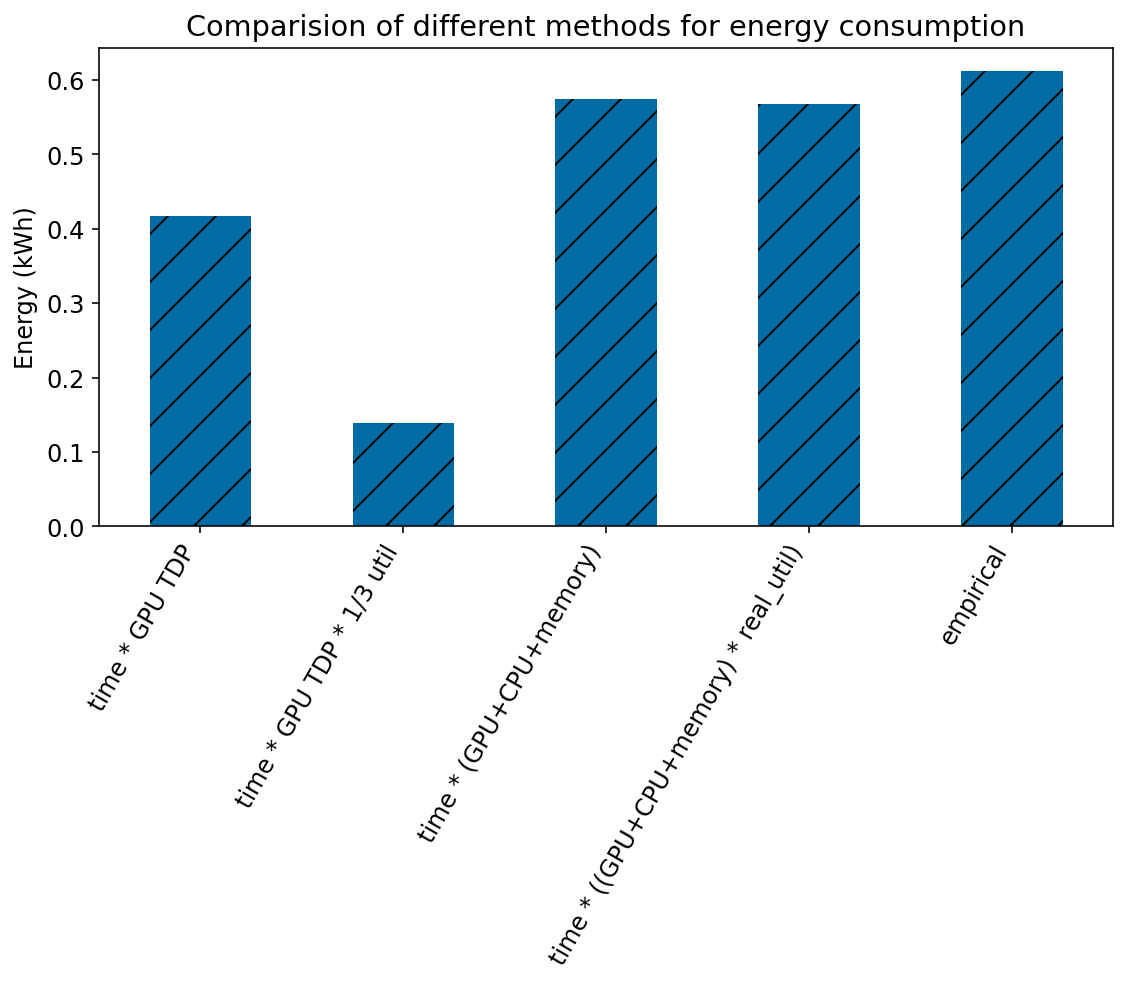

In [462]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
df.plot.bar(x='method', y='energy', rot=60,title="Comparision of different methods for energy consumption",
            ax=ax, legend=False)

bars = ax.patches
hatches = ''.join(h*len(df) for h in '/x\.')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.set_xlabel("")
ax.set_ylabel("Energy (kWh)")
ax.set_xticklabels(df.method, rotation=60, fontdict={'horizontalalignment': 'right','size':12})
plt.tight_layout()
ax.figure.savefig("viz/compareEnergy.png",dpi=300)

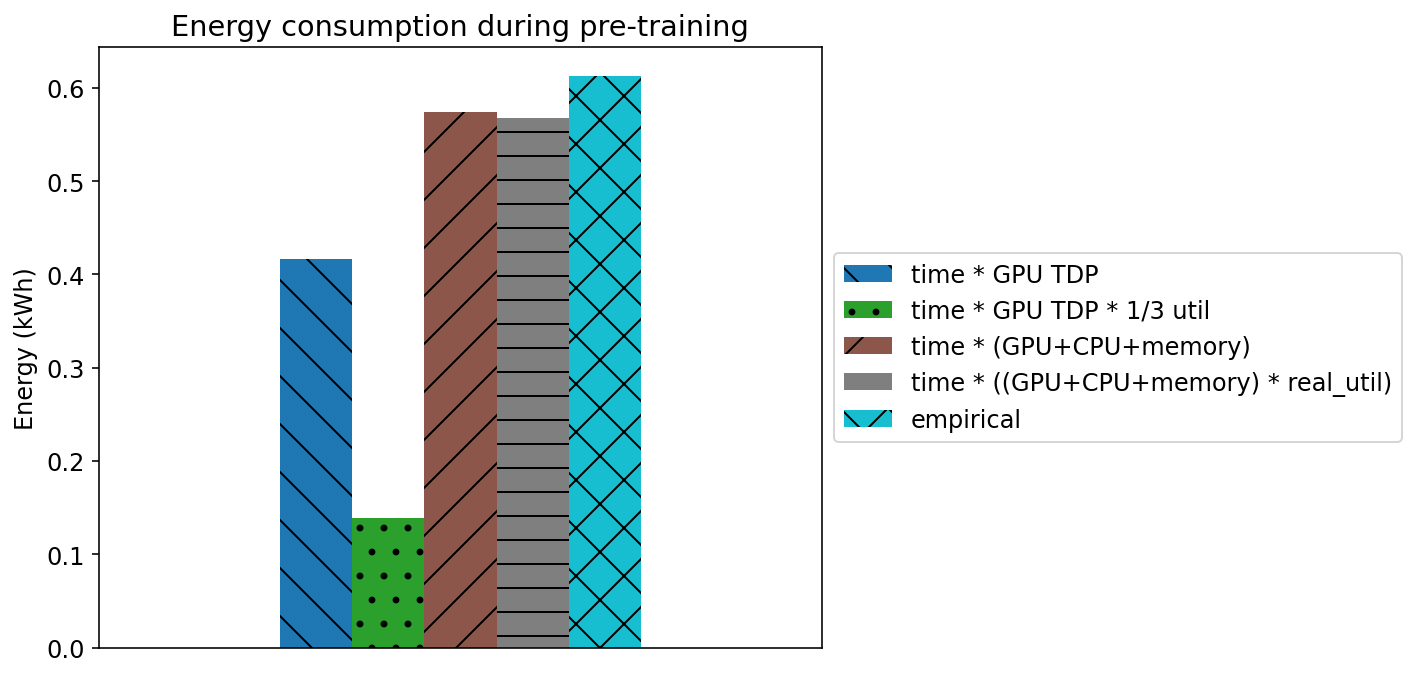

In [501]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
alt_df.plot.bar(rot=0, ax=ax, legend=False, colormap='tab10')

bars = ax.patches
hatches = ''.join(h*len(alt_df) for h in '\./-x')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Energy (kWh)")
ax.set_xlabel(" ")
ax.set_xticks([])
ax.set_title("Energy consumption during pre-training")
plt.tight_layout()
ax.figure.savefig("viz/pretrainCompareEnergy.png",dpi=300)

In [358]:
percent_lesser =( power_monitor_reading - full_util )/ power_monitor_reading
percent_lesser

0.06243749307312081

## Test correlation

In [360]:
power_monitor_df = pd.read_csv("results/pretrain_power_monitor.csv")

In [361]:
power_monitor_df['last_changed'] = pd.to_datetime(power_monitor_df['last_changed'], errors='coerce')
power_monitor_df.dropna(subset=['last_changed'], inplace=True)
power_monitor_df.set_index('last_changed', inplace=True)

In [362]:
start_date = '2020-06-16'
end_date = '2020-06-16'
start_time = '21:38:59' #one hour behind
end_time = '23:18:51'
subset_df = power_monitor_df.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
total_energy_pm = ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600) #sampled every 3 sec
total_energy_pm

0.6127022608333333

In [363]:
end = '2020-06-17 00:18:51.137000'
start = '2020-06-16 22:38:59.567000'

start = datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
end = datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)   

# start_time = [start for i in range(0,95,5)] 
# end_time = [start + timedelta(hours=0, minutes=i)
#                  for i in range(5,100,5)] 

In [364]:
# try normal distribution
mu, sigma = 50, 20 # mean and standard deviation
s = np.random.normal(mu, sigma, 100)

In [365]:

end_time = [start + timedelta(hours=0, minutes=i)
                 for i in s if i >=0] 
start_time = [start for i in range(len(end_time))] 

In [366]:
# total energy consumed
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = power_monitor_df.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600)

In [367]:
df_time_interval= pd.DataFrame(start_time,columns=['start'])

In [368]:
df_time_interval['end'] = end_time
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end"]]

In [369]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'empirical'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [371]:
# the model with utilisation 
def model_based(time):
    return (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation +memory_TDP) / (1000 * 3600) )

In [372]:
for index, row in df_time_interval.iterrows(): 
    time = row['end'] - row['start']
    seconds = time.total_seconds()
    df_time_interval.at[index,'model_based'] = model_based(seconds)

In [373]:
df_time_interval.tail()

,start,end,s_date,e_date,s_time,e_time,empirical,model_based
93,2020-06-16 21:38:59.567,2020-06-16 21:56:21.637980,2020-06-16,2020-06-16,21:38:59,21:56:21,0.104725,0.098547
94,2020-06-16 21:38:59.567,2020-06-16 22:04:39.006820,2020-06-16,2020-06-16,21:38:59,22:04:39,0.155299,0.145582
95,2020-06-16 21:38:59.567,2020-06-16 22:12:44.253882,2020-06-16,2020-06-16,21:38:59,22:12:44,0.203790,0.191471
96,2020-06-16 21:38:59.567,2020-06-16 22:01:15.316336,2020-06-16,2020-06-16,21:38:59,22:01:15,0.134715,0.126319
97,2020-06-16 21:38:59.567,2020-06-16 22:42:38.935573,2020-06-16,2020-06-16,21:38:59,22:42:38,0.388454,0.361191


coeff: 0.9999308032043928
r2: 0.999861611196982


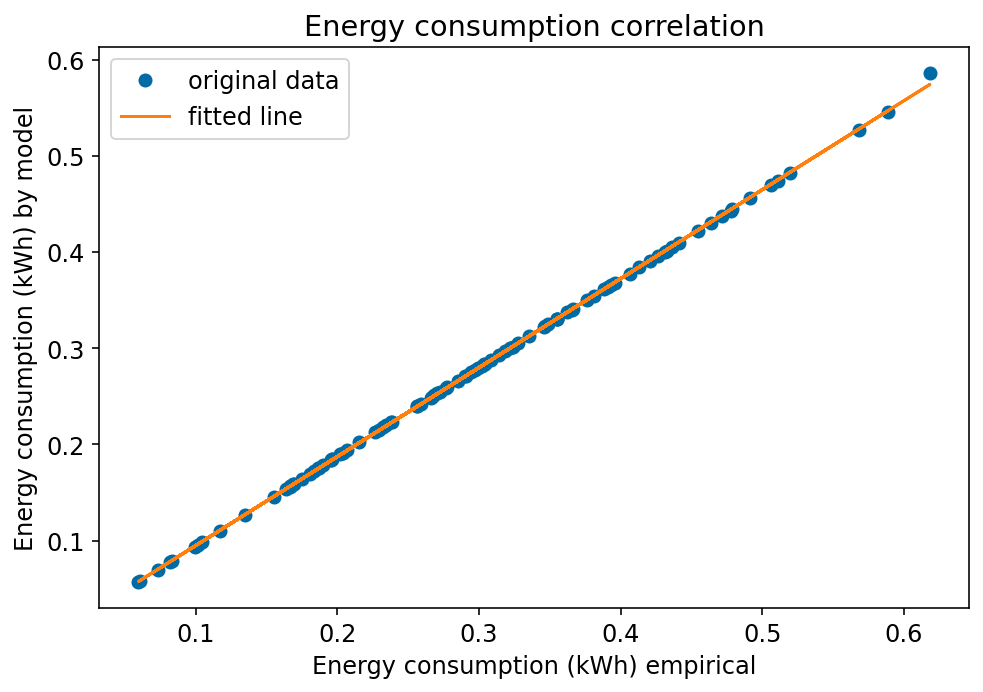

In [374]:
x = df_time_interval['empirical']
y = df_time_interval['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/pretrain_model_vs_empirical.png',dpi=300)

In [375]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.022057519410097842 
 mae: 0.01988917604682789


## See how the values scale with time using finetuning training 

In [376]:
df_finetune = pd.read_csv("results/model_pm_energy_finetune.csv")

In [377]:
df_finetune.columns

Index(['dataset', 'batchsize', 'max_seq_len', 'mean_power', 'total_time',
       'power', 'summed_power', 'gpu_util', 'gpu1_util', 'gpu2_util',
       'gpu1_mean_power', 'gpu2_mean_power', 'memory_util', 'memory_used',
       'start_time', 'end_time', 'total_energy', 'cpu_time', 'dataset_size',
       'total_batchsize', 'samples_per_sec', 'time_per_sample', 'TFLOPs',
       'PFLOPs', 'PFLOPs_per_example', 'start_seconds', 'end_seconds',
       's_date', 'e_date', 's_time', 'e_time', 'pm_mean_power', 'pm_power',
       'pm_energy_consumption', 'CO2e', 'kg CO2e/kWh', 'time_in_hour'],
      dtype='object')

In [378]:
df_finetune['power'].count()

51

In [379]:
df_finetune['time * GPU TDP'] = df_finetune['total_time']/3600 *( GPU_TDP * 2) / 1000
df_finetune['time * (GPU + CPU + memory)'] =((df_finetune['total_time']/3600 * GPU_TDP *2) + 
                                             (df_finetune['cpu_time']/3600 * (CPU_TDP + memory_TDP))) / 1000
df_finetune['time * (GPU + CPU + memory) * real_util'] = ((df_finetune['total_time']/3600 *  GPU_TDP * 2* df_finetune['gpu_util']/100 )
  + (df_finetune['cpu_time']/3600 * (CPU_TDP * CPU_utilisation + memory_TDP))) / 1000

In [380]:
df_64 = df_finetune.loc[(df_finetune.batchsize == 64) & (df_finetune.max_seq_len == 128)]
df_64 = df_64.sort_values('dataset_size')
features = ['dataset','gpu_util','time * GPU TDP','time * (GPU + CPU + memory)','time * (GPU + CPU + memory) * real_util', 'pm_energy_consumption']
df_64[features]

,dataset,gpu_util,time * GPU TDP,time * (GPU + CPU + memory),time * (GPU + CPU + memory) * real_util,pm_energy_consumption
1,WNLI,86.753205,0.001822,0.002325,0.002083,0.001955
2,RTE,90.220930,0.006041,0.007340,0.006749,0.007000
7,MRPC,93.104839,0.008735,0.010543,0.009940,0.009915
15,STS-B,95.063168,0.014237,0.017110,0.016407,0.016306
19,CoLA,92.684397,0.019933,0.023881,0.022423,0.022874
29,SST-2,93.989130,0.157824,0.187833,0.178346,0.181335
36,QNLI,94.669243,0.246555,0.293343,0.280199,0.287262
48,QQP,93.259980,0.416589,0.495241,0.467163,0.453297
47,QQP,93.643194,0.166705,0.198179,0.187582,0.186924
46,QQP,93.229384,0.499961,0.594354,0.560503,0.538160


In [381]:
features = ['dataset','time * GPU TDP','time * (GPU + CPU + memory)',
            'time * (GPU + CPU + memory) * real_util','pm_energy_consumption','kg CO2e/kWh']
bert_finetune = df_64[features]
bert_finetune.to_csv("results/bert_finetune_appendix.csv", index=False)

In [382]:
df_plot = df_64[df_64['dataset'].isin(['MRPC','CoLA','SST-2','MNLI'])]

In [383]:
features = ['dataset','time * GPU TDP','time * (GPU + CPU + memory)','time * (GPU + CPU + memory) * real_util', 'pm_energy_consumption']
df_plot = df_plot[features]
df_plot.rename(columns={'pm_energy_consumption':'empirical', 'dataset':'model'},
                   inplace=True)
df_plot.set_index('model', inplace=True)

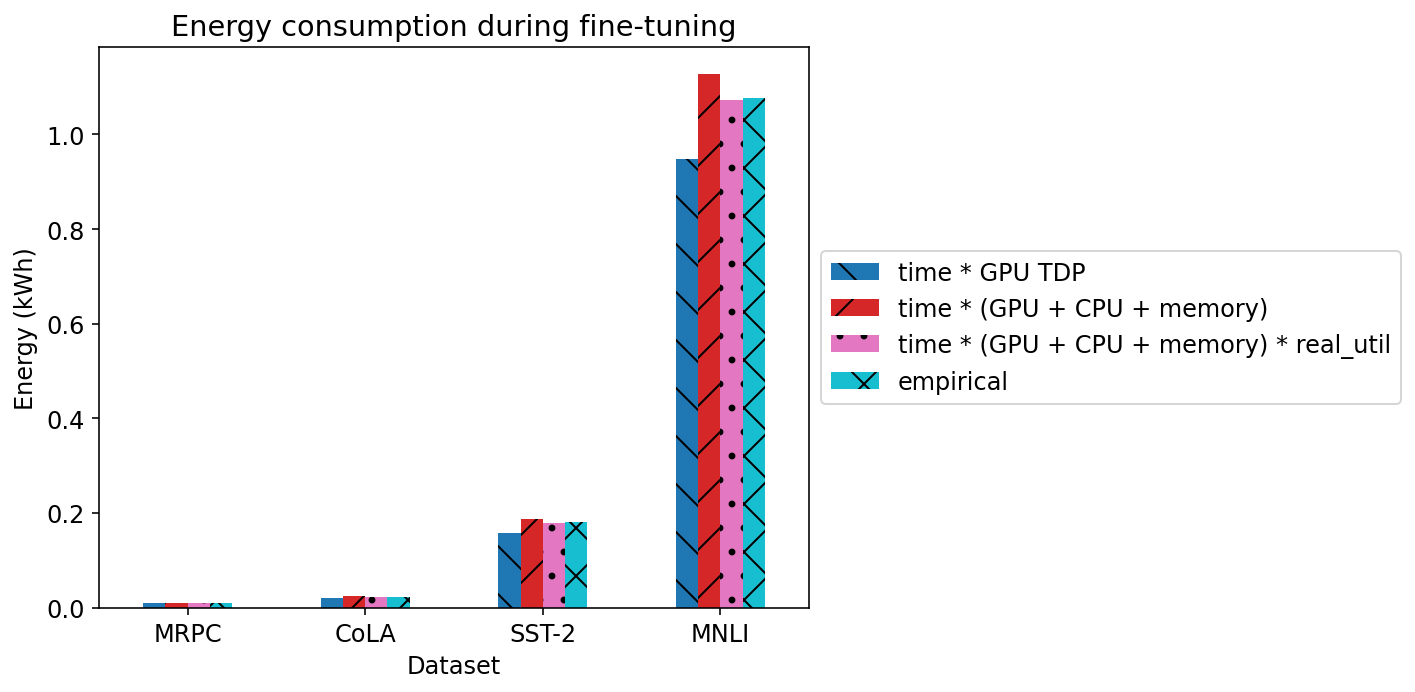

In [384]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
df_plot.plot.bar(rot=0, ax=ax, legend=False, colormap='tab10')

bars = ax.patches
hatches = ''.join(h*len(df_plot) for h in '\/.x')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel("Energy (kWh)")
ax.set_xlabel("Dataset")
ax.set_title("Energy consumption during fine-tuning")
plt.tight_layout()
ax.figure.savefig("viz/finetuneCompareEnergy.png",dpi=300)

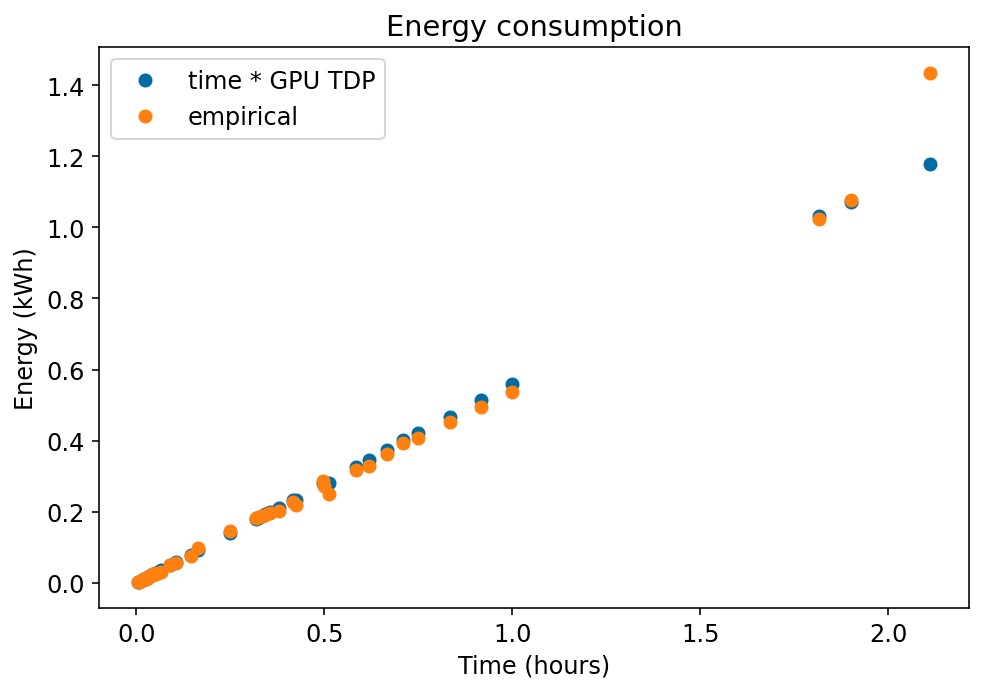

In [385]:
x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU + memory) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
plt.plot(x, y1,'o', label="time * GPU TDP")
plt.plot(x, y2,'o', label="empirical")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/mlco2ModelVsPMPower.png',dpi=300)

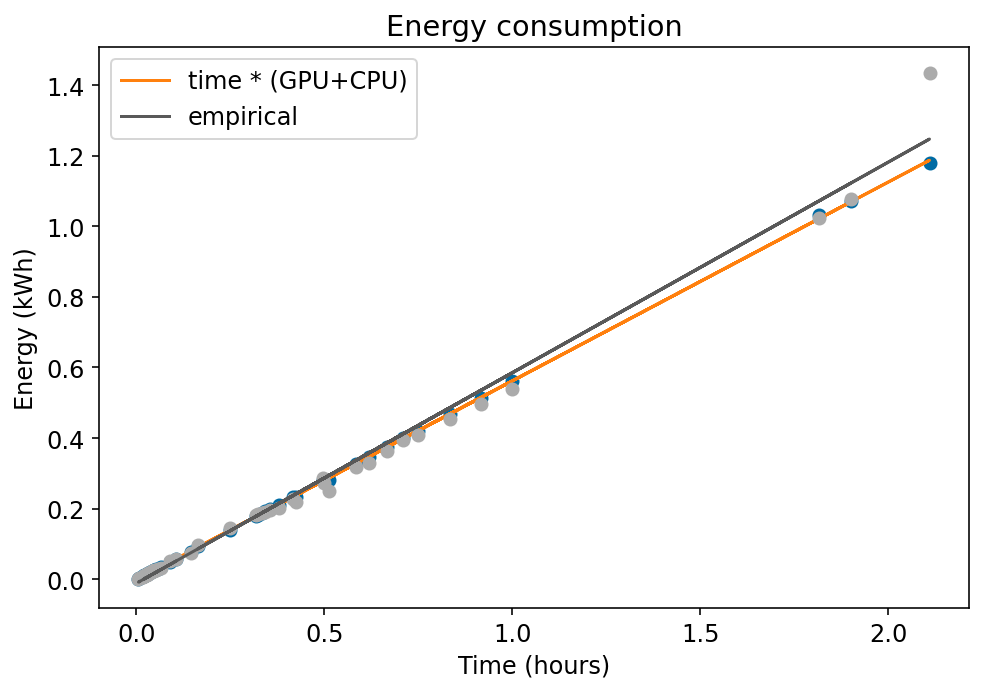

In [386]:
x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU + memory) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
plt.plot(x, y1,'o')
plt.plot(x, slope * x + intercept, label='time * (GPU+CPU)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
plt.plot(x, y2,'o')
plt.plot(x, slope * x + intercept, label='empirical')
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/CPU_GPU_ModelVsPMPower.png',dpi=300)

In [387]:
stat, p = stats.normaltest(x)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=35.997, p=0.000
Sample does not look Gaussian (reject H0)


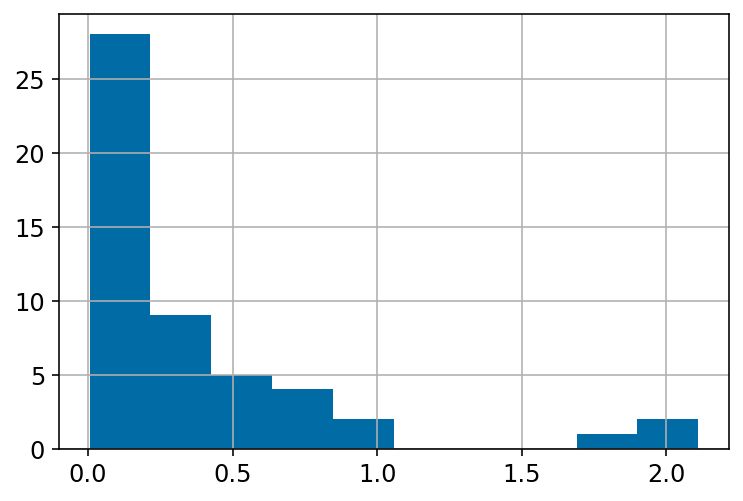

In [388]:
x.hist()

In [389]:
df_64 = df_finetune.loc[(df_finetune.batchsize == 64) & (df_finetune.max_seq_len == 128)]
df_64 = df_64.sort_values('dataset_size')

coeff: 0.9935378919827168
r2: 0.9871175428054606


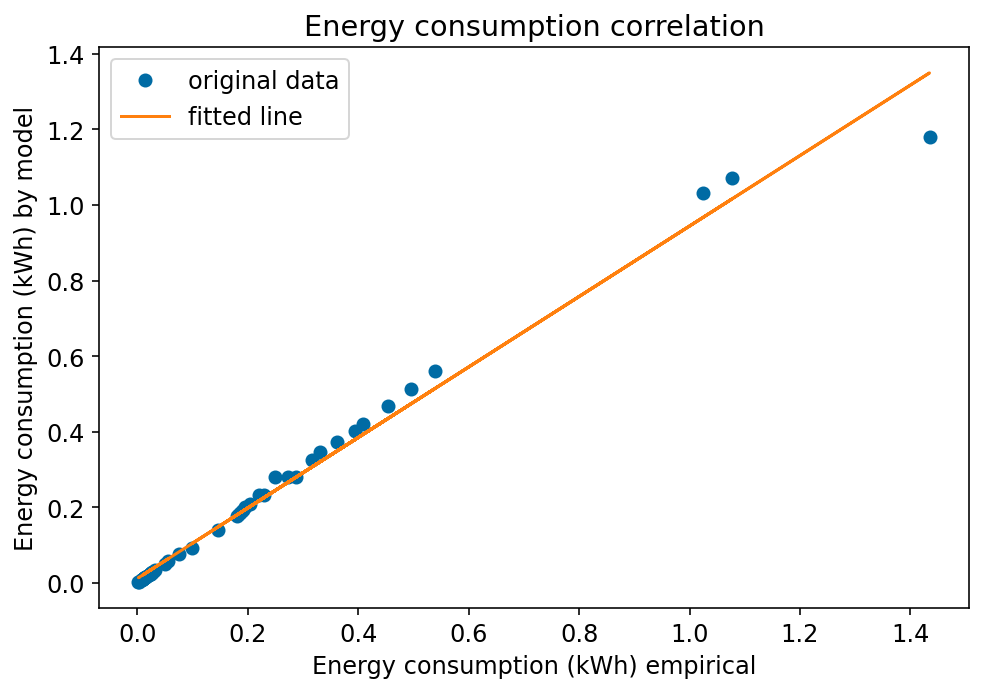

In [390]:
x = df_finetune['pm_energy_consumption']
y = df_finetune['time * (GPU + CPU + memory) * real_util']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.ylabel("Energy consumption (kWh) by model")
plt.xlabel("Energy consumption (kWh) empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)

In [391]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.036590675533907 
 mae: 0.009673895167497995


coeff: 0.9995518546123844
r2: 0.9991039100590572


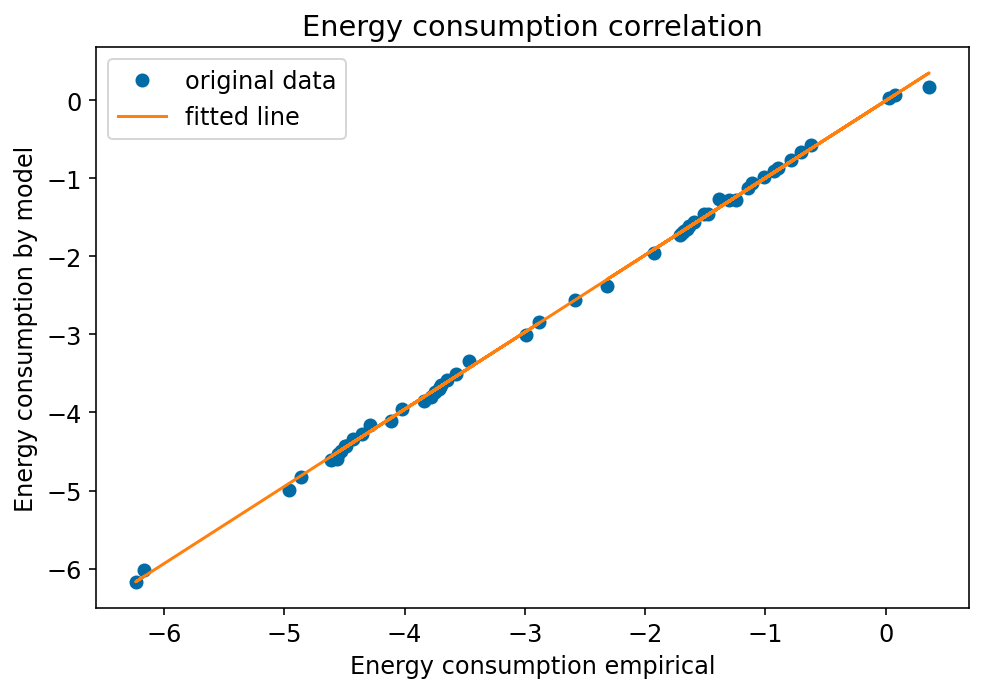

In [392]:
## try log

x = np.log(df_finetune['pm_energy_consumption'])
y = np.log(df_finetune['time * (GPU + CPU + memory) * real_util'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.ylabel("Energy consumption by model")
plt.xlabel("Energy consumption empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)

## merge data 

In [393]:
df_finetune.rename(columns={'pm_energy_consumption':'empirical','time * (GPU + CPU + memory) * real_util':'model_based'},
                   inplace=True)

In [394]:
merge_df = df_finetune.append(df_time_interval)

coeff: 0.9949733108096304
r2: 0.9899718892234773


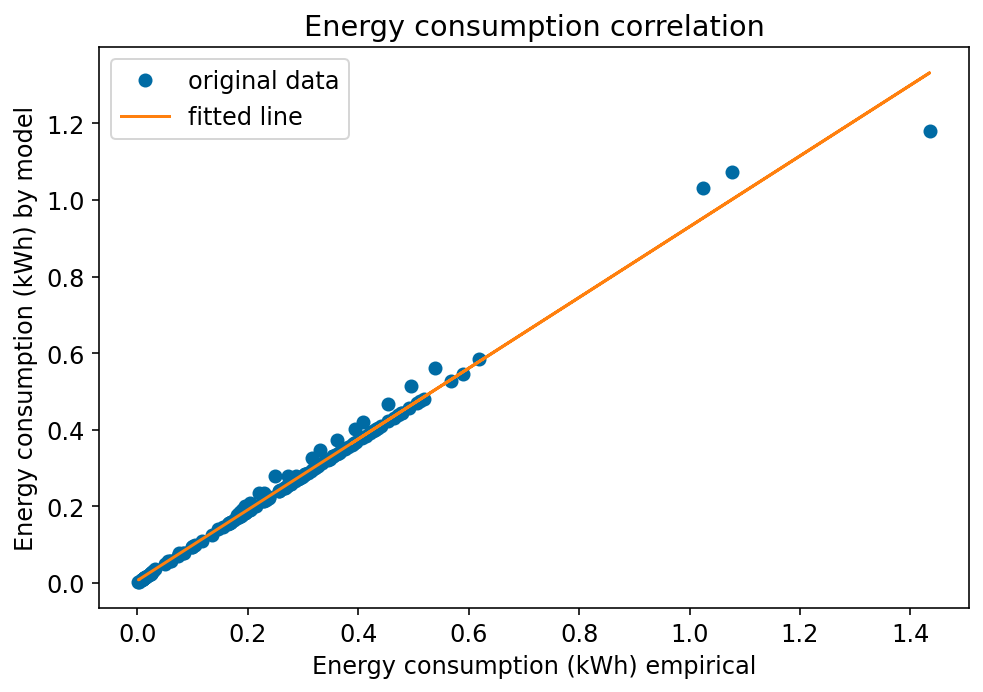

In [395]:
x = merge_df['empirical']
y = merge_df['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/model_vs_empirical.png',dpi=300)

In [396]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.02789759584852777 
 mae: 0.016392670510949874


coeff: 0.9993953357552783
r2: 0.9987910371294054


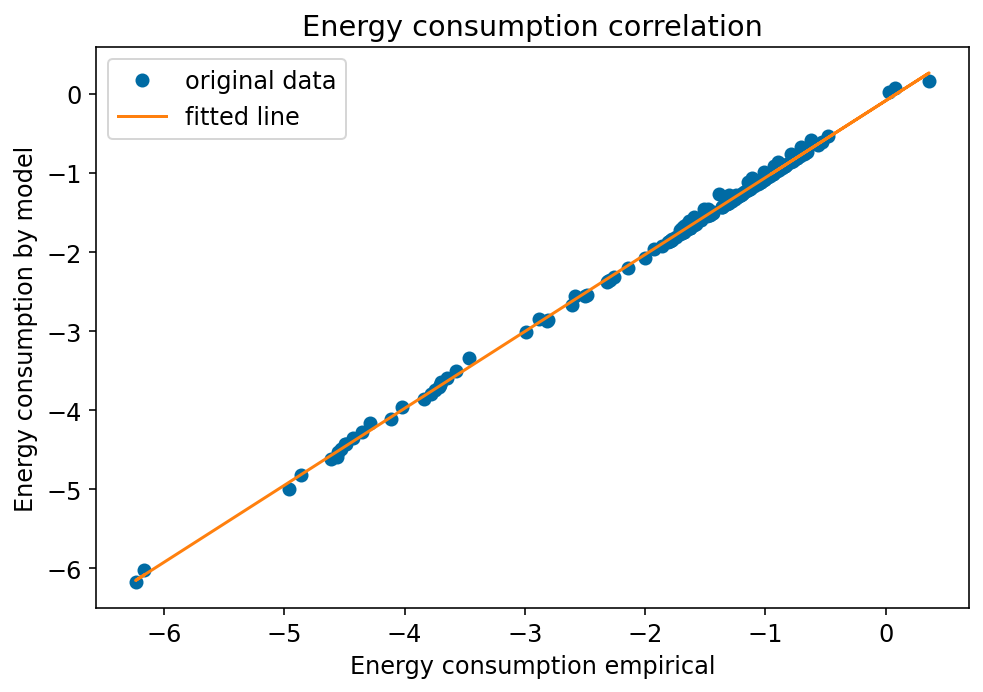

In [397]:
#log 
x = np.log(merge_df['empirical'])
y = np.log(merge_df['model_based'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption empirical")
plt.ylabel("Energy consumption by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_model_vs_empirical.png',dpi=300)

In [398]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.06518280810400319 
 mae: 0.05969154292406662


## Merge inference data

In [400]:
infer = pd.read_csv("results/inferenceProcessedData.csv",)
infer

,model,time * GPU TDP,time * (GPU + CPU + memory),time * (GPU + CPU + memory) * real_util,empirical
0,STS-B,0.024742,0.034111,0.020551,0.023768
1,CoLA,0.024321,0.033504,0.019435,0.021950
2,MRPC,0.024812,0.034208,0.020581,0.023455


In [402]:
infer.rename(columns={'time * (GPU + CPU + memory) * real_util':'model_based'},
                   inplace=True)

In [403]:
new_df = merge_df.append(infer)

coeff: 0.9950995174889509
r2: 0.9902230497067428
p-value:  1.2037365065778556e-152
rmse: 0.02762388687365567 
 mae: 0.01612573912546618
mse:  0.000763079126008526


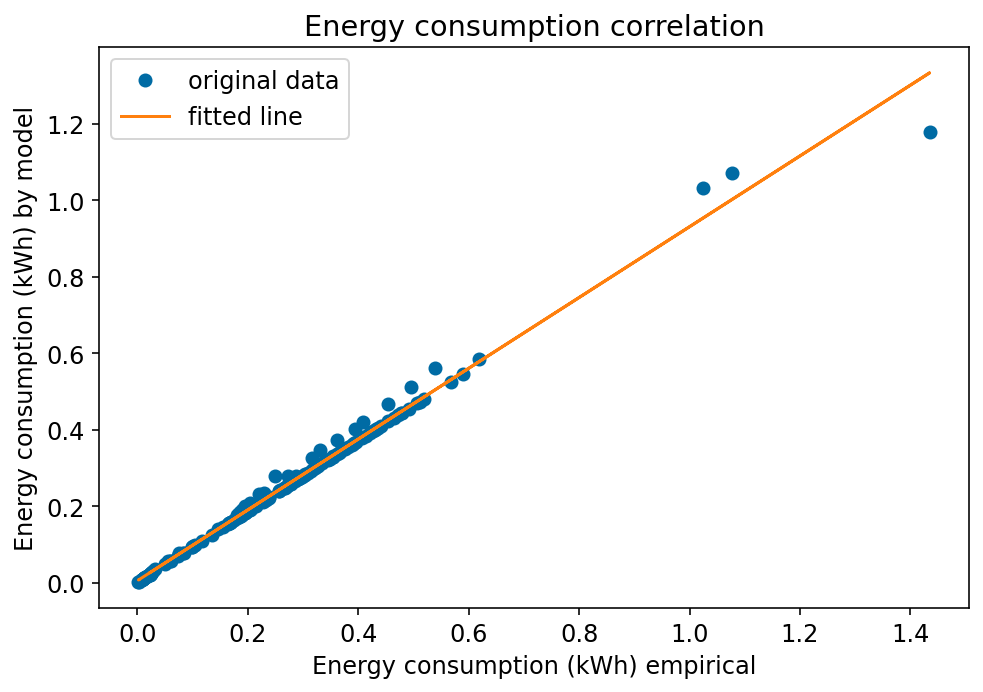

In [404]:
x = new_df['empirical']
y = new_df['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
print("p-value: ", p_value)
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/model_vs_empiricalAll.png',dpi=300)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")
print("mse: ",mse)

coeff: 0.9992912417604392
r2: 0.9985829858591204


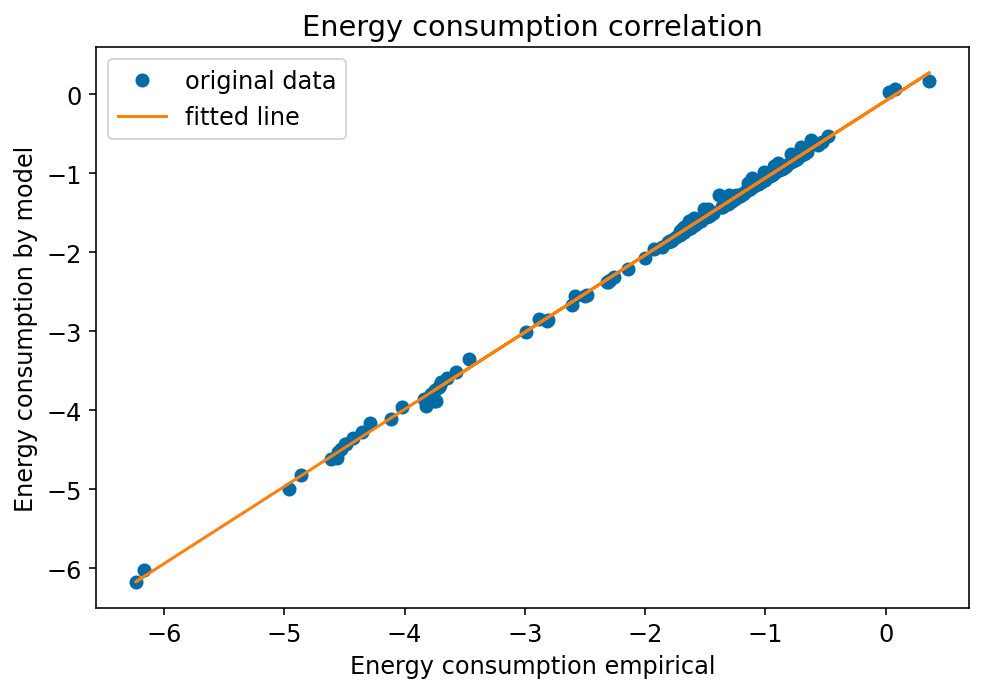

In [405]:
#log 
x = np.log(new_df['empirical'])
y = np.log(new_df['model_based'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption empirical")
plt.ylabel("Energy consumption by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_model_vs_empiricalAll.png',dpi=300)

## Ridge regression

In [406]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()
x = new_df['empirical'].values.reshape(-1, 1)
y = new_df['model_based'].values

parameters = {"alpha":[1e-20,1e-15,1e-10,1e-7,1e-4,1e-3,1e-2,1,5,10,20]}

ridge_regressor = GridSearchCV(ridge,parameters,scoring="neg_mean_squared_error",cv=5)
ridge_regressor.fit(x,y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-20, 1e-15, 1e-10, 1e-07, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20]},
             scoring='neg_mean_squared_error')

In [407]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)
print(ridge_regressor.score(x,y))

{'alpha': 1e-15}
-0.0003679755962355807
-0.00035058752009232714


In [506]:
df_co2 = pd.read_csv("results/co2data.csv")
uk_co2 = df_co2.loc[df_co2.country == 'United Kingdom'].impact.mean()
# uk_co2 = 0.23314 + 0.02005
uk_co2

253.0

Bert base trained on 64 V100 for 79 hours (from nlp paper)

In [507]:
V100TDP = 300 # watt
numGPU = 64
time = 79 # hour
util = 0.63 # assumption from related work
pue = 1.67 
energy = pue * time * V100TDP * numGPU * util /1000
print(f"{energy} kWh")

1595.82528 kWh


Bert base on 16 TPU for 4 days (96 hours)

In [508]:
TPUv2 = 250
numTPU = 16
time = 96
util = 0.9
pue = 1.67
energy_base = pue * time * TPUv2 * numTPU * util /1000
co2 = energy_base * uk_co2 /1000
print(f"{energy_base} kWh")
print(f"co2 : {co2}")

577.152 kWh
co2 : 146.01945600000002


bert large on 64 TPU for 4 days

In [509]:
TPUv2 = 250
numTPU = 64
time = 96
util = 0.9
pue = 1.67
energy_large = pue * time * TPUv2 * numTPU * util /1000
co2 = energy_large * uk_co2 /1000
print(f"{energy_large} kWh")
print(f"co2 : {co2}")

2308.608 kWh
co2 : 584.0778240000001


In [510]:
df_plot = df_co2.sort_values('impact')
df = df_plot[['country','impact']].groupby('country').mean()
df.sort_values('impact', inplace=True)
df.reset_index(inplace=True)

In [511]:
df['bert_large'] = energy_large * df['impact'] / 1000
df['bert_base'] = energy_base * df['impact']/1000

In [512]:
df

,country,impact,bert_large,bert_base
0,Switzerland,11.000000,25.394688,6.348672
1,Canada,30.000000,69.258240,17.314560
2,Sweden,47.000000,108.504576,27.126144
3,Brazil,90.000000,207.774720,51.943680
4,France,100.000000,230.860800,57.715200
5,Finland,120.000000,277.032960,69.258240
6,United Kingdom,253.000000,584.077824,146.019456
7,Belgium,270.000000,623.324160,155.831040
8,Ireland,348.000000,803.395584,200.848896
9,Germany,370.000000,854.184960,213.546240


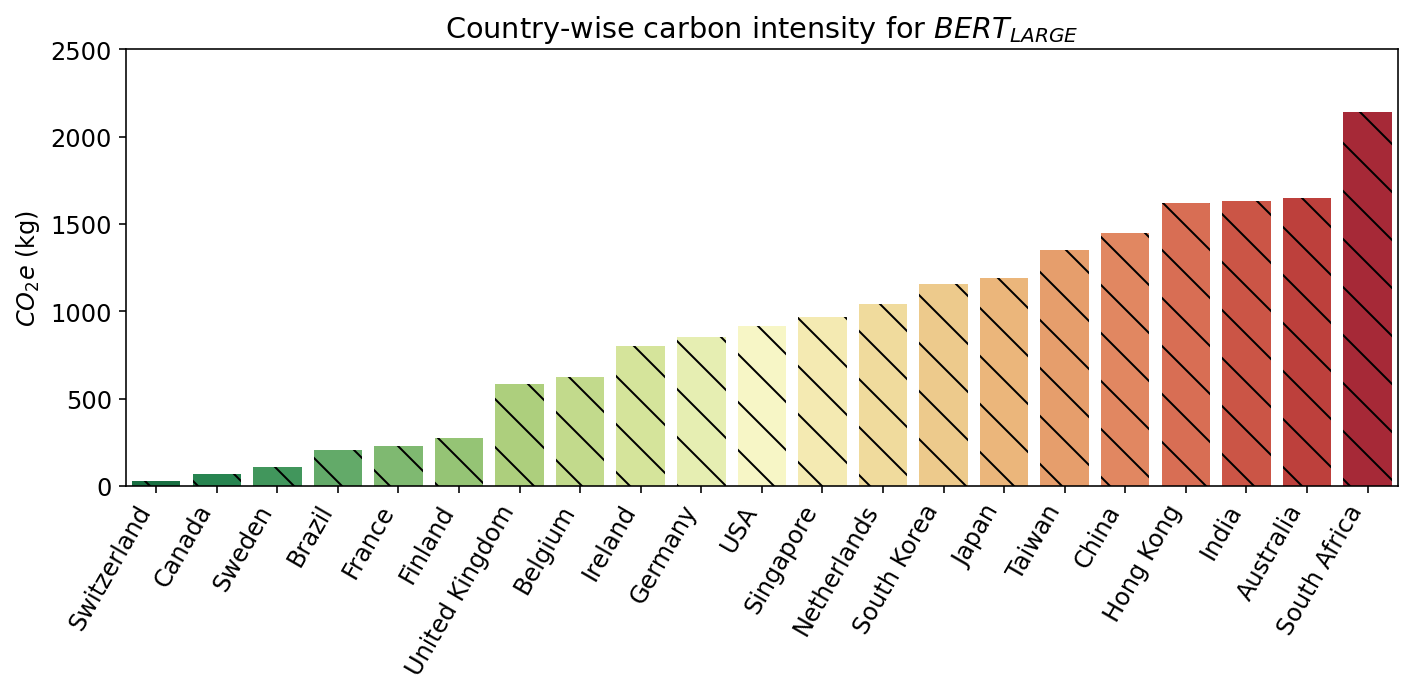

In [513]:
fig, ax = plt.subplots(figsize=(10,5))
# ax.vlines(x=df.index, ymin=0, ymax=df.bert_large, color='indianred',  linewidth=2)
# ax.scatter(x=df.index, y=df.bert_large, s=75, color='indianred')
ax = sns.barplot(x='country',y='bert_large',data=df,palette='RdYlGn_r')
bars = ax.patches
hatches = ''.join(h*len(df) for h in '\/.x')

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
ax.set_title('Country-wise carbon intensity for $BERT_{LARGE}$')
ax.set_ylabel('$CO_2e$ (kg)')
ax.set_xlabel('')
ax.set_xticks(df.index)
ax.set_xticklabels(df.country, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 2500)
plt.tight_layout()
plt.savefig('viz/bertlarge_countrywiseco2.png', dpi=300)